In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, Input, MaxPool2D, 
                         UpSampling2D, Concatenate, Conv2DTranspose, 
                         Dropout)
import tensorflow as tf
from keras.optimizers import Adam,SGD
from keras.initializers import he_normal
from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import (array_to_img, img_to_array, 
                                       load_img, ImageDataGenerator)
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
import keras.backend as K
import itchat
from wechat_utils import SendMessage
import random
from importlib import reload

import pdb
import gc
import sys

Using TensorFlow backend.


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import keras
keras.__version__

'2.0.6'

## Prepare the data

In [3]:
# Set the necessary directories
data_dir = '../data/train/'
mask_dir = '../data/train_masks/'
all_images = os.listdir(data_dir)

In [4]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [5]:
tmp_dir = './tmp/u-net-dropout-momentum/'

In [6]:
!mkdir ./tmp/u-net-dropout-momentum/

mkdir: cannot create directory ‘./tmp/u-net-dropout-momentum/’: File exists


In [7]:
# Train validation split
train_images, validation_images = train_test_split(
    all_images, train_size=0.8, test_size=0.2)

In [8]:
# original size 1280, 1918
input_dims = [1280, 1792]
batch_size = 1

In [9]:
# Utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j]) * 3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [10]:
def read_image_and_mask(data_dir, mask_dir, image):
    return (load_img(data_dir + image), 
            load_img(mask_dir + image.split('.')[0] + '_mask.gif'))

In [11]:
def show_image_and_mask(image, mask):
    plt.figure()
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)

(1792, 1280)
[[ 236.  232.  233.]
 [ 236.  232.  233.]
 [ 236.  232.  233.]
 ..., 
 [ 195.  199.  202.]
 [ 195.  199.  202.]
 [ 195.  199.  202.]]


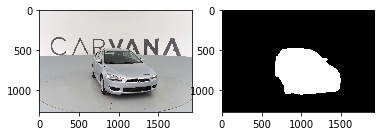

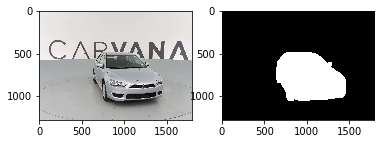

In [12]:
def random_crop_along_width(image_pair, dims):
    image, mask = image_pair
    assert dims[0] == 1280, "wrong dims"
    x_s = random.randint(0, 1918 - dims[1])
    box = (x_s, 0, x_s+dims[1], dims[0])
    image = image.crop(box)
    mask = mask.crop(box)
    return image, mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = random_crop_along_width((image_, mask_), input_dims)
show_image_and_mask(image_, mask_)
print (image_.size)
print (img_to_array(image_)[:, input_dims[1]-1])

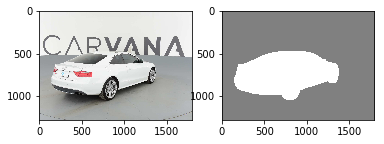

In [13]:
transforms = [lambda image_pair: random_crop_along_width(image_pair, input_dims)]
from data_utils import data_gen_small, threadsafe_iter
import data_utils
reload(data_utils)
del globals()['data_gen_small']
from data_utils import data_gen_small
            
# Example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, batch_size, 
                          input_dims, transforms=transforms)
img, msk = next(train_gen)

plt.subplot(121)
plt.imshow(img[0])
plt.subplot(122)
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [14]:
%%time
_ = next(train_gen)

CPU times: user 116 ms, sys: 8 ms, total: 124 ms
Wall time: 139 ms


In [30]:
val_gen = data_gen_small(data_dir, mask_dir, validation_images, 0, input_dims)

In [31]:
_ = next(val_gen)

  0%|          | 1/1018 [00:00<02:59,  5.65it/s]

Build generator, this may take some time...
total number of images: 1018


100%|██████████| 1018/1018 [02:53<00:00,  5.32it/s]


In [32]:
image_, mask_ = next(val_gen)
print (image_.shape)
print (mask_.shape)

(1018, 1280, 1792, 3)
(1018, 1280, 1792, 1)


In [33]:
image_, mask_ = next(train_gen)
print (image_.shape)
print (mask_.shape)
print (mask_[0].shape)
print (mask_[0][16])

(1, 1280, 1792, 3)
(1, 1280, 1792, 1)
(1280, 1792, 1)
[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]


## Build the network

In [19]:
# First, let's define the two different types of layers that we will 
# be using
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', 
                   kernel_initializer=he_normal(), activation='relu')(
                   input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', 
                      kernel_initializer=he_normal(), activation='relu')(
                      conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool,residual
    else:
        return residual
    
def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same', 
                    kernel_initializer=he_normal(), activation='relu')(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same',
                   kernel_initializer=he_normal(), activation='relu')(
                   concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', 
                   kernel_initializer=he_normal(), activation='relu')(
                   conv1)
    return conv2


In [34]:
K.clear_session()
# Make a custom U-nets implementation
filters = 32

input_layer = Input(shape=[None, None] + [3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

# Down 2, 64
filters = filters * 2
d2, res2 = down(d1, filters)
residuals.append(res2)

# Down 3 32
filters = filters * 2
d3, res3 = down(d2, filters)
residuals.append(res3)

# Down 4, 16
filters = filters * 2
d4, res4 = down(d3, filters)
residuals.append(res4)

# Down 5, 8
filters = filters * 2
d4 = Dropout(0.5)(d4)
d5 = down(d4, filters, pool=False)
d5 = Dropout(0.5)(d5)

# Up 1
filters = filters / 2
up1 = up(d5, residual=residuals[-1], filters=filters)

# Up 2,3,4
up_ = up1
for layer_i in range(3):
    filters = filters / 2
    up_ = up(up_, residual=residuals[-(layer_i + 2)], filters=filters)
    
# Out, or up 5
out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(), 
             activation='sigmoid')(up_)

model = Model(input_layer, out)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, None, None, 32 9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, None, None, 32 0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [21]:
# Now let's use Tensorflow to write our dice_coefficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape((y_true), [-1]))
    y_pred = tf.round(tf.reshape((y_pred), [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [35]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 'weights.hdf5',
                             verbose=1, save_best_only=True)
csv_logger = CSVLogger(tmp_dir + 'training.log')
send_message = SendMessage(fexten=tmp_dir)

In [36]:
#optimizer = SGD(lr=0.001, momentum=0.99)
optimizer = Adam(beta_1=0.99)
model.compile(optimizer=optimizer, loss='binary_crossentropy', 
             metrics=[dice_coef])

In [ ]:
# For keras 2.0.5, the max_queue_size should be max_q_size
# no relu in 2x2 conv, no advanced initializer
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=2, 
                              initial_epoch=0)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., validation_steps=inf, initial_epoch=0, validation_data=(array([[[..., steps_per_epoch=4096.0, workers=1, max_queue_size=6, epochs=2, callbacks=[<keras.ca...)`
  # This is added back by InteractiveShellApp.init_path()
Start auto replying.


Epoch 1/2
1965/4096 [=============>................] - ETA: 6334s - loss: 0.1384 - dice_coef: 0.8714

In [43]:
def decrease_lr(optimizer):
    lr = K.get_value(optimizer.lr)
    K.set_value(optimizer.lr, lr / 10)
    print ('Decrease learning rate, now is {}'.format(lr / 10))
decrease_lr(optimizer)

Decrease learning rate, now is 0.00010000000474974513


In [32]:
# For keras 2.0.5, the max_queue_size should be max_q_size

history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=2, 
                              epochs=4, 
                              initial_epoch=2)

Start auto replying.


Epoch 3/4
2047/2048 [============================>.] - ETA: 0s - loss: 0.0562 - dice_coef: 0.9665Epoch 00002: val_loss improved from 0.06076 to 0.05483, saving model to ./tmp/u-net-32-no-filter-growth/weights.hdf5


Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se


Conection error,failed to send the figure!



Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se


Conection error,failed to send the message!



Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se


Conection error,failed to send the figure!



Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se


Conection error,failed to send the message!


Conection error,failed to send the message!

2048/2048 [==============================] - 431s - loss: 0.0562 - dice_coef: 0.9665 - val_loss: 0.0548 - val_dice_coef: 0.9710

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se


Conection error,failed to send the message!

Epoch 4/4
   1/2048 [..............................] - ETA: 224s - loss: 0.0521 - dice_coef: 0.9680

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se

  85/2048 [>.............................] - ETA: 315s - loss: 0.0532 - dice_coef: 0.9706

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se

 194/2048 [=>............................] - ETA: 330s - loss: 0.0530 - dice_coef: 0.9709

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se

2048/2048 [==============================] - 436s - loss: 0.0534 - dice_coef: 0.9715 - val_loss: 0.0560 - val_dice_coef: 0.9656


In [33]:
decrease_lr(optimizer)

Decrease learning rate, now is 0.00010000000474974513


In [34]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=4, 
                              initial_epoch=2)

Start auto replying.


Epoch 3/4
2048/2048 [==============================] - 419s - loss: 0.0515 - dice_coef: 0.9750 - val_loss: 0.0484 - val_dice_coef: 0.9742
Epoch 4/4
2048/2048 [==============================] - 434s - loss: 0.0506 - dice_coef: 0.9767 - val_loss: 0.0485 - val_dice_coef: 0.9701


Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se

LOG OUT!


In [35]:
decrease_lr(optimizer)

Decrease learning rate, now is 1.0000000474974514e-05


In [36]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=2, 
                              epochs=5, 
                              initial_epoch=4)

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 387, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 383, in _make_request
    httplib_response = conn.getresponse()
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
Start auto replying.  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/http/client.py", line 297, in begin
    version, status, reason = self._read_status()

  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/http/client.py", line 258, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/home/luo/anaconda2/envs/tf11/lib/pyt


Conection error,failed to send the message!

Epoch 5/5
2047/2048 [============================>.] - ETA: 0s - loss: 0.0503 - dice_coef: 0.9775Epoch 00004: val_loss improved from 0.04838 to 0.04549, saving model to ./tmp/u-net-32-no-filter-growth/weights.hdf5


Traceback (most recent call last):
  File "/home/luo/dlnd/car-segmentation/car-segmentation/wechat_utils.py", line 94, in t_send_img
    itchat.send_image(filename,toUserName=toUserName)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/itchat/components/messages.py", line 419, in send_image
    r = self.upload_file(fileDir, isPicture=not fileDir[-4:] == '.gif', file_=file_)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/itchat/components/messages.py", line 331, in upload_file
    file_, chunk, chunks, uploadMediaRequest)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/itchat/components/messages.py", line 354, in upload_chunk_file
    ('webwx_data_ticket', (None, cookiesList['webwx_data_ticket'])),
KeyError: 'webwx_data_ticket'



Conection error,failed to send the figure!



Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se


Conection error,failed to send the message!



Traceback (most recent call last):
  File "/home/luo/dlnd/car-segmentation/car-segmentation/wechat_utils.py", line 94, in t_send_img
    itchat.send_image(filename,toUserName=toUserName)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/itchat/components/messages.py", line 419, in send_image
    r = self.upload_file(fileDir, isPicture=not fileDir[-4:] == '.gif', file_=file_)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/itchat/components/messages.py", line 331, in upload_file
    file_, chunk, chunks, uploadMediaRequest)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/itchat/components/messages.py", line 354, in upload_chunk_file
    ('webwx_data_ticket', (None, cookiesList['webwx_data_ticket'])),
KeyError: 'webwx_data_ticket'



Conection error,failed to send the figure!



Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se


Conection error,failed to send the message!


Conection error,failed to send the message!

2048/2048 [==============================] - 425s - loss: 0.0503 - dice_coef: 0.9775 - val_loss: 0.0455 - val_dice_coef: 0.9753

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se



Conection error,failed to send the message!



Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/socket.py", line 743, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    se

In [100]:
decrease_lr(optimizer)

Decrease learning rate, now is 9.99999901978299e-06


Start auto replying.


Epoch 6/6
2048/2048 [==============================] - 441s - loss: 0.0526 - dice_coef: 0.9729 - val_loss: 0.0537 - val_dice_coef: 0.9689


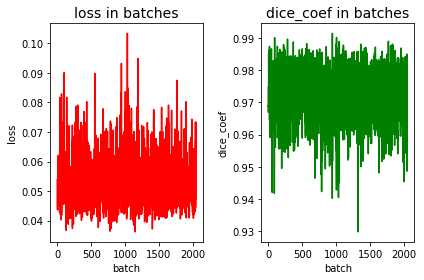

In [101]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=2, 
                              epochs=6, 
                              initial_epoch=5)